# Week 5 - Predicting Redshift with Decision Trees
#### 

In [31]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold

### Loading the Sloan Digital Sky Survey (SDSS) Catalogue

In [3]:
data = np.load('sdss_galaxy_colors.npy')     # NumPy structured array

### Extracting Features & Targets

In [35]:
def get_features_targets(data):
  features = np.zeros(((np.shape(data)[0]),4))
  features[:,0] = data['u'] - data['g']
  features[:,1] = data['g'] - data['r']
  features[:,2] = data['r'] - data['i']
  features[:,3] = data['i'] - data['z']
  targets = data['redshift']
  return features, targets

features, targets = get_features_targets(data)

# print the shape of the returned arrays
print(features[:2])
print(targets[:2])

[[0.31476 0.0571  0.28991 0.07192]
 [1.2002  0.82026 0.45294 0.24665]]
[0.539301  0.1645703]


###### 

### Decision Tree Regressor

In [15]:
# initialize model
dtr = DecisionTreeRegressor()

# train the model
dtr.fit(features, targets)

# make predictions using the same features
predictions = dtr.predict(features)

# print out the first 4 predicted redshifts
print(predictions[:4])

[0.539301   0.1645703  0.04190006 0.04427702]


###### 

### Validating the model

In [20]:
def median_diff(predicted, actual):
  return np.median(abs(predicted-actual))


def validate_model(model, features, targets):
  
  # split the data into training and testing features and predictions
  split = features.shape[0]//2
  train_features, test_features = features[:split], features[split:]
  train_targets, test_targets = targets[:split], targets[split:]
  
  # train the model
  model.fit(train_features, train_targets)
  
  # get the predicted_redshifts
  predictions = model.predict(test_features)
  
  # use median_diff function to calculate the accuracy
  return median_diff(test_targets, predictions)


# validate the model and print the med_diff
diff = validate_model(dtr, features, targets)
print('Median difference: {:f}'.format(diff))


Median difference: 0.021891


###### 

### Colour-Colour Redshift Plot

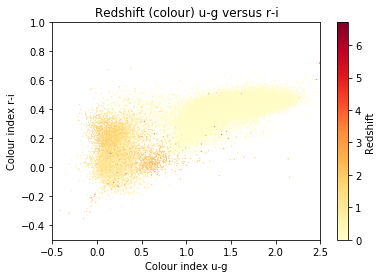

In [27]:
# Get a colour map
cmap = plt.get_cmap('YlOrRd')

# Define our colour indexes u-g and r-i
color1 = data['u'] - data['g']
color2 = data['r'] - data['i']

# Make a redshift array
redshift = data['redshift']

# Create the plot with plt.scatter and plt.colorbar
plt.scatter(color1, color2, s = 1, c = redshift, cmap = cmap, lw = 0)
plt.colorbar().set_label('Redshift')

# Define your axis labels and plot title
plt.title('Redshift (colour) u-g versus r-i')
plt.xlabel('Colour index u-g')
plt.ylabel('Colour index r-i')

# Set any axis limits
plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1.0)

plt.show()

###### 

### Avoiding overfitting by setting maximum tree depth

Depth with lowest median difference : 21



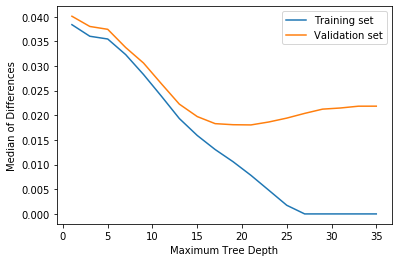

In [43]:
def accuracy_by_treedepth(features, targets, depths):
  
  # split the data into testing and training sets
  
  split = features.shape[0]//2
  train_features, test_features = features[:split], features[split:]
  train_targets, test_targets = targets[:split], targets[split:]
  
  # initialise arrays or lists to store the accuracies for the below loop
  scores_train, scores_test = [], []

  # loop through depths
  
  for depth in depths:
    # initialize model with the maximum depth. 
    dtr = DecisionTreeRegressor(max_depth=depth)

    # train the model using the training set
    dtr.fit(train_features, train_targets)
    
    # get the predictions for the training set and calculate their median_diff
    pred_train = dtr.predict(train_features)
    scores_train.append(median_diff(pred_train, train_targets))
    
    # get the predictions for the testing set and calculate their median_diff
    pred_test = dtr.predict(test_features)
    scores_test.append(median_diff(pred_test, test_targets))
        
  # return the accuracies for the training and testing sets
  return scores_train, scores_test


# Generate several depths to test
tree_depths = [i for i in range(1, 36, 2)]

# Call the function
train_med_diffs, test_med_diffs = accuracy_by_treedepth(features, targets, tree_depths)
print("Depth with lowest median difference : {}\n".format(tree_depths[test_med_diffs.index(min(test_med_diffs))]))

# Plot the results
train_plot = plt.plot(tree_depths, train_med_diffs, label='Training set')
test_plot = plt.plot(tree_depths, test_med_diffs, label='Validation set')
plt.xlabel("Maximum Tree Depth")
plt.ylabel("Median of Differences")
plt.legend()
plt.show()

###### 

### k-fold Cross Validation

In [40]:
def cross_validate_model(model, features, targets, k):
  kf = KFold(n_splits=k, shuffle=True)

  # initialise a list to collect median_diffs for each iteration of the loop below
  results = []
  
  for train_indices, test_indices in kf.split(features):
    train_features, test_features = features[train_indices], features[test_indices]
    train_targets, test_targets = targets[train_indices], targets[test_indices]
    
    # fit the model for the current set
    model.fit(train_features, train_targets)
    
    # predict using the model
    prediction = model.predict(test_features)
 
    # calculate the median_diff from predicted values and append to results array
    results.append(median_diff(prediction, test_targets))
 
  # return the list with your median difference values
  return results


# initialize model with a maximum depth of 19
dtr = DecisionTreeRegressor(max_depth=19)

# call the cross validation function
diffs = cross_validate_model(dtr, features, targets, 10)

# Print the values
print('Differences: {}'.format(', '.join(['{:.3f}'.format(val) for val in diffs])))
print('Mean difference: {:.3f}'.format(np.mean(diffs)))

Differences: 0.017, 0.017, 0.017, 0.017, 0.018, 0.017, 0.018, 0.018, 0.017, 0.018
Mean difference: 0.017


###### 

### k-fold Cross Validated Predictions

Median difference: 0.017



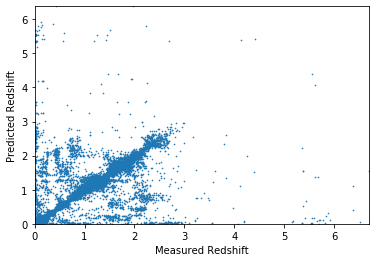

In [42]:
def cross_validate_predictions(model, features, targets, k):
  kf = KFold(n_splits=k, shuffle=True)

  # declare an array for predicted redshifts from each iteration
  all_predictions = np.zeros_like(targets)

  for train_indices, test_indices in kf.split(features):
    
    # split the data into training and testing
    train_features, test_features = features[train_indices], features[test_indices]
    train_targets, test_targets = targets[train_indices], targets[test_indices]
       
    # fit the model for the current set
    model.fit(train_features, train_targets)

    # predict using the model
    predictions = model.predict(test_features)
        
    # put the predicted values in the all_predictions array defined above
    all_predictions[test_indices] = predictions

  # return the predictions
  return all_predictions    


# initialize model
dtr = DecisionTreeRegressor(max_depth=19)

# call the cross validation function
predictions = cross_validate_predictions(dtr, features, targets, 10)

# calculate and print the rmsd as a sanity check
diffs = median_diff(predictions, targets)
print('Median difference: {:.3f}\n'.format(diffs))

# plot the results to see how well our model looks
plt.scatter(targets, predictions, s=0.4)
plt.xlim((0, targets.max()))
plt.ylim((0, predictions.max()))
plt.xlabel('Measured Redshift')
plt.ylabel('Predicted Redshift')
plt.show()

###### 

### Splitting the data into Quasi Stellar Objects (QSO) and Galaxies

In [45]:
def split_galaxies_qsos(data): 
  # split the data into galaxies and qsos arrays
  galaxies = data[data['spec_class'] == b'GALAXY']
  qsos = data[data['spec_class'] == b'QSO']

  # return the seperated galaxies and qsos arrays
  return galaxies, qsos


def cross_validate_median_diff(data):
  features, targets = get_features_targets(data)
  dtr = DecisionTreeRegressor(max_depth=19)
  return np.mean(cross_validate_model(dtr, features, targets, 10))


# Split the data set into galaxies and QSOs
galaxies, qsos = split_galaxies_qsos(data)

# Here we cross validate the model and get the cross-validated median difference
# The cross_validated_med_diff function is in "written_functions"
galaxy_med_diff = cross_validate_median_diff(galaxies)
qso_med_diff = cross_validate_median_diff(qsos)

# Print the results
print("Median difference for Galaxies: {:.3f}".format(galaxy_med_diff))
print("Median difference for QSOs: {:.3f}".format(qso_med_diff))

Median difference for Galaxies: 0.016
Median difference for QSOs: 0.075


###### 

### Predicted Redshift values for QSOs & Galaxies

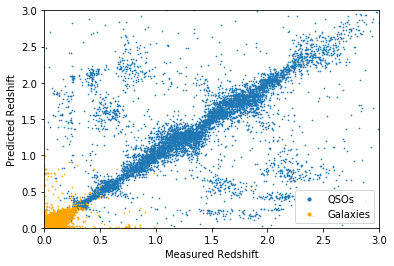

In [57]:
galaxy_features, galaxy_targets = get_features_targets(galaxies)
qso_features, qso_targets = get_features_targets(qsos)

galaxy_predictions = cross_validate_predictions(dtr, galaxy_features, galaxy_targets, 10)
qso_predictions = cross_validate_predictions(dtr, qso_features, qso_targets, 10)

l1 = plt.scatter(qso_targets, qso_predictions, s=0.4)
l2 = plt.scatter(galaxy_targets, galaxy_predictions, s=0.4, color='orange')
plt.xlim((0, 3))
plt.ylim((0, 3))
plt.xlabel('Measured Redshift')
plt.ylabel('Predicted Redshift')
plt.legend((l1, l2), ('QSOs', 'Galaxies'), markerscale = 5)
plt.show()